**BÁO CÁO BÀI TẬP LỚN MÔN HỌC MÁY**

**Giảng viên** : Trần Quốc Long

**Lớp** : INT 3405E 20

**Họ và tên** : Nguyễn Thị Nhung

**MSSV** : 19021343

**MÔ TẢ BÀI TOÁN:**

Quora là nền tảng để mọi người có thể học hỏi lẫn nhau bằng cách đặt câu hỏi và trả lời để chia sẻ kiến thức. Mục đích của bài toán này là để phân loại các câu hỏi đặt ra là thuộc loại câu hỏi chân thành hay không chân thành, giúp loại bỏ những câu hỏi thiếu chân thành - những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích.
* Mục tiêu: Xác định những câu hỏi nào là câu hỏi toxic
* Input: Câu hỏi dạng văn bản
* Output: 0/1(Sincere/ Insincere)

**PHÂN TÍCH DỮ LIỆU, CONVERT, CLEAN DỮ LIỆU**

Import các thư viện cần thiết:


In [ ]:
import pandas as pd 
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import seaborn as sns
import re
import string
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

Đọc dữ liệu đầu vào 

In [ ]:
train = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
test = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')

Dữ liệu được cung cấp gồm 2 file chính là train.csv và test.csv.

In [ ]:
print("Train:")
display(train.head())
print('\n')
print("Test:")
display(test.tail())

Có thể thấy rằng tập train có 3 trường dữ liệu:
* qid : định danh id cho câu hỏi
* question_text: nội dung câu hỏi
* target: phân loại ứng với từng câu hỏi( 1 ứng với câu hỏi không chân thành và 0 ứng với câu hỏi chân thành)
* không có dữ liệu nào bất thường(missing, null)

In [ ]:
print("Tổng số dữ liệu trong tập train: ",train.shape[0])
print("Số câu hỏi chân thành: ", len(train[train.target == 0]))
print("Số câu hỏi không chân thành: ",len(train[train.target == 1]))
print("Tỉ lệ giữa 2 lớp: ",len(train[train.target == 1])/len(train[train.target == 0]))
print('\n')

ax, fig = plt.subplots(figsize=(10, 7))
question_class = train["target"].value_counts()
question_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

Dựa vào biểu đồ trên, ta có thể thấy rõ sự mất cân bằng giữa số câu hỏi không chân thành với số câu hỏi chân thành( tỉ lệ 1:15) khiến tập dữ liệu bị mất cân bằng. Điều này dẫn đến:
* Đánh giá sai chất lượng mô hình: sự mất cân bằng có thể khiến thước đo đánh giá mô hình là độ chính xác (accuracy) có thể đạt được rất cao mà không cần tới mô hình. Minh chứng đơn giản với bộ dữ liệu trên thì nếu kết quả dự đoán đưa ra tất cả đều có target = 0 thì độ chính xác đã đạt 94%.
* Mô hình dự đoán kém chính xác: sự mất cân bằng có thể gây hiện tượng Overfitting, khiến kết quả dự đoán ra thường nghiêng về nhóm đa số và kém trên nhóm thiểu số trong khi tầm quan trọng của việc dự báo được chính xác một mẫu thuộc nhóm thiểu số lớn hơn nhiều so với dự báo mẫu thuộc nhóm đa số. ( VD ở đây việc quan trọng nhất là xác định được nhóm câu hỏi không chân thành)
Vì vậy, với bài toán này ta cần sử dụng các metric thay thế accuracy như : F1, Recall,....
Với bài toán này ta sẽ chọn: [F1-score](http://en.wikipedia.org/wiki/F-score)

F1_score là trung bình điều hòa giữa precision (độ chính xác) và recall (độ bao phủ)

Precision: trong tập tìm được thì bao nhiêu cái (phân loại) đúng.

Recall: trong số các tồn tại, tìm ra được bao nhiêu cái (phân loại).



**Khảo sát tần xuất các từ xuất hiện trong tập dữ liệu**

* **Word Cloud**

In [ ]:
def cloud(docs, title):
    wordcloud = WordCloud(width = 750, height = 450, collocations = False, background_color="white").generate(" ".join(docs))
    fig = plt.figure(figsize=(10,7), facecolor='w')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=25,color='k')
    plt.tight_layout(pad=0)
    plt.show()
data_neg = train[train['target']==0]
data_pos = train[train['target']==1]
cloud(data_neg.question_text, "Sincere question")
cloud(data_pos.question_text, "Insincere question")

**Nhận xét**

* Word Cloud là một kỹ thuật trực quan hóa dữ liệu được sử dụng để biểu diễn dữ liệu văn bản, trong đó kích thước của mỗi từ cho biết tần suất hoặc tầm quan trọng của nó.

* 2 word cloud khá tương tự nhau (khi so sánh về các từ nổi bật)

* Các danh từ riêng xuất hiện nhiều hơn ở câu không chân thành

**Clean dữ liệu**

* Bỏ đi các biểu thức toán học và các đường dẫn liên kết

* Bỏ đi các ký tự đặc biệt, các chữ số, chữ hoa chữ thường (chỉ giữ lại số và chữ)

* Sửa những từ sai chính tả và chuẩn hóa dạng đầy đủ của các từ viết tắt

* Sau khi thử thì em thấy stop_word không ảnh hưởng nhiều lắm nên không loại bỏ


**Các hàm xử lý dữ liệu đã chọn**

* clean_tag : Đưa các biểu thức toán học về "MATH EQUATION" và đưa đường dẫn web về "URL".Bởi vì các biểu thức toán học và các đường link thường không mang nhiều ý nghĩa, không những vậy nó còn có thể gây ra nhiễu.

* clean_punct: Loại bỏ dấu và các kí tự đặc biệt.

* correct_mispell: Sửa lại các từ viết sai chính tả và đưa một số từ về dạng thông dụng.Do dữ liệu được thu thập trên Qoura, nên không thể tránh được việc bị sai chính tả. Nên việc sửa các từ bị sai chính tả là cần thiết, mục đích cũng giống với sửa các từ viết tắt. Nhưng ta không thể biết được hết các khả năng sai chính tả được, nên mình sẽ chỉ sửa những từ sai chính tả thường gặp, hoặc thay thế một số từ tối nghĩa thành từ đồng nghĩa với nó.
 
* contraction_mapping: Đưa viết tắt về dạng không viết tắt.
Riêng về stopword, em nhân thấy rằng sau khi bỏ thì khả năng phân loại của mô hình bị giảm xuống, nên phần xử lý dữ liệu em sẽ để nguyên stopword


In [ ]:
# Xứ lý kí tự toán học và link URL
def clean_tag(x):
  if '[math]' in x:
    x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    
  if 'http' in x or 'www' in x:
    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
  return x

In [ ]:
# Loại bỏ kí tự đặc biệt
# Nguồn: https://www.kaggle.com/canming/ensemble-mean-iii-64-36
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞''◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']
def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
  return x


In [ ]:
# Sửa từ viết sai và đưa một số từ về dạng thông dụng.
# Nguồn: https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime','cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu','weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_mispell(x):
  words = x.split()
  for i in range(0, len(words)):
    if mispell_dict.get(words[i]) is not None:
      words[i] = mispell_dict.get(words[i])
    elif mispell_dict.get(words[i].lower()) is not None:
      words[i] = mispell_dict.get(words[i].lower())
        
  words = " ".join(words)
  return words

In [ ]:
# Bỏ viết tắt
# Nguồn: https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 

contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": 
                       "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not",
                       "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": 
                       "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": 
                       "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", 
                       "He'll": "He will", "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": 
                       "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", 
                       "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", 
                       "She's": "She is", "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": 
                       "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": 
                       "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", 
                       "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": 
                       "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": 
                       "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": 
                       "How is", "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", 
                       "Shouldn't":"Should not", "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": 
                       "It is", "Isn't":"Is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": 
                       "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                       "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                       "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                       "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll"
                       : "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": 
                       "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": 
                       "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": 
                       "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't"
                       : "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": 
                       "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": 
                       "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": 
                       "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": 
                       "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": 
                       "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
                       "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": 
                       "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": 
                       "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
        text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [ ]:
# Gọi tất cả các hàm tiền xử lý dữ liệu trên
def data_cleaning(x):
  x = clean_tag(x)
  x = clean_punct(x)
  x = correct_mispell(x)
  x = clean_contractions(x)
#x = remove_stopwords(x)
  return x

In [ ]:
#Tạo ra 1 tập dữ liệu đã được cleaning
train['question_text_cleaned'] = train['question_text'].apply(lambda x: data_cleaning(x))
test['question_text_cleaned'] = test['question_text'].apply(lambda x: data_cleaning(x))
display(train.head(),test.head())

**HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH**

Ta cần chia tập train thành 2 phần để huấn luyện và đánh giá mô hình.

Cách đơn giản nhất là ta có thể lấy ngẫu nhiên một tập dữ liệu con từ tập train để làm tập validation. Tuy nhiên vì sự chêch lệch tỉ lệ quá lớn khiến tập validation khi lấy có thể xảy ra trường hợp  chứa toàn bộ dữ liệu thuộc cùng một lớp

Giải pháp: lấy ngẫu nhiên dữ liệu từ từng lớp. Ví dụ với bộ dữ liệu hiện tại, ta muốn tạo ra tập validation có tỉ lệ 1:10 từ tập train thì ta lấy ta 1/10 dữ liệu từ lớp có target = 0 và 1/10 dữ liệu từ tập target = 1.

Sử dụng hàm train_test_split() của sklearn để chia tập theo phương pháp trên.

In [ ]:
def test_funtion_split():
    X = train.question_text
    y = train.target
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Tỉ lệ giữa 2 lớp trong tập train",len(y_train[y_train == 0])/len(y_train[y_train == 1]))
    print("Tỉ lệ giữa 2 lớp trong tập test",len(y_val[y_val == 0])/len(y_val[y_val == 1]))

test_funtion_split()

**Mô hình được chọn:** LinearSVC

LinearSVC giúp ta tìm được đường phân chia giữa 2 lớp sao cho margin là lớn nhất. Việc margin rộng hơn sẽ mang lại hiệu ứng phân lớp tốt hơn vì sự phân chia giữa hai classes là rạch ròi hơn.

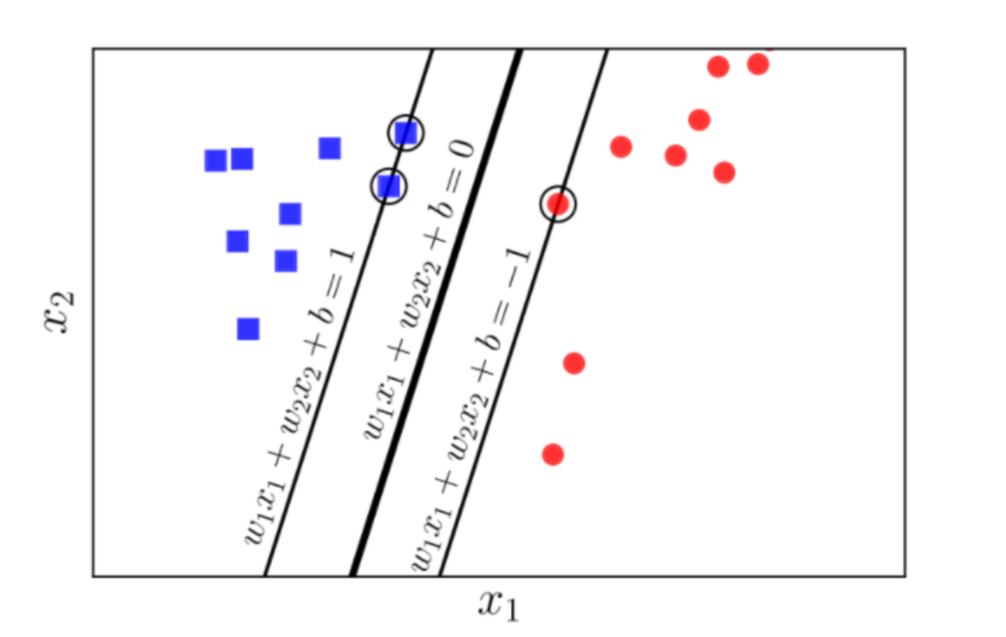

**Tiền xử lý dữ liệu**
1. CountVectorizer
được sử dụng để chuyển đổi một bộ sưu tập các tài liệu văn bản thành một vectơ có số lượng thuật ngữ / mã thông báo.

In [ ]:
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,3))

In [ ]:
#Hàm dự đoán sử dụng linear
def predict_linearSVC(X_train,y_train,X_test):
    count_vectorizer.fit(X_train)
    X_train = count_vectorizer.transform(X_train)
    X_test = count_vectorizer.transform(X_test)
    svm = LinearSVC()
    svm.fit(X_train,y_train)
    return svm.predict(X_test)
#Dự đoán trên tập validation
def validate_base_model():
    X = train.question_text
    y = train.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    predict = predict_linearSVC(X_train,y_train,X_test)
    return f1_score(predict,y_test)

In [ ]:
print('F1-Score của base-model trên tập validation: ',validate_base_model())

2. TF-IDF ( [Tài liệu tham khảo](https://vi.wikipedia.org/wiki/Tf%E2%80%93idf))

Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 3))

In [ ]:
#Hàm dự đoán sử dụng linear
def predict_linearSVC(X_train,y_train,X_test):
    tfidf.fit(X_train)
    X_train = tfidf.transform(X_train)
    X_test = tfidf.transform(X_test)
    svm = LinearSVC()
    svm.fit(X_train,y_train)
    return svm.predict(X_test)
 
#Dự đoán trên tập validation
def validate_base_model():
    X = train.question_text
    y = train.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    predict = predict_linearSVC(X_train,y_train,X_test)
    return f1_score(predict,y_test)

In [ ]:
print('F1-Score của base-model trên tập validation: ',validate_base_model())

**Nhận xét :**

* Đầu tiên ta sử dụng CountVectorizer nhưng nó không hiệu quả

* Thay vào đó sử dụng TF-IDF hiệu quả hơn

In [ ]:
def create_file_submission(predict):
    submission = pd.DataFrame(test['qid'])
    submission['prediction'] = predict
    submission.to_csv('submission.csv', index=False)
    
def submit_base_model():
    X_train = train['question_text']
    y_train = train.target
    X_test = test['question_text']
    predict = predict_linearSVC(X_train,y_train,X_test)
    create_file_submission(predict)

In [ ]:
#submit_base_model()

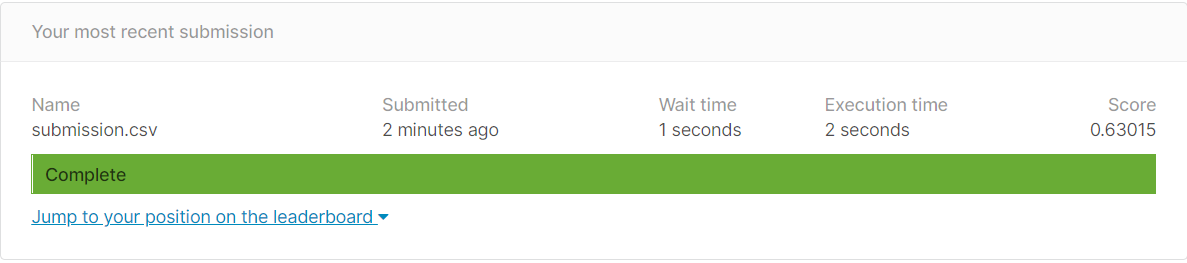

**Nhận xét :**

Điểm số đạt được trên tập test khá tương đồng với điểm số trên tập validation cho thấy tập validation đã đánh giá chính xác hiệu năng của model đồng thời cho thấy mô hình không xảy ra các hiện tượng underfiting, overfiting.

**THỰC NGHIỆM**

In [ ]:
def validate_baseModel_dataCleaded():
    X = train.question_text_cleaned
    y = train.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    predict = predict_linearSVC(X_train,y_train,X_test)
    return f1_score(predict,y_test)

print("F1-Score trên tập dữ liệu đã xử lý: ",validate_baseModel_dataCleaded())

In [ ]:
def submit():
    X_train = train['question_text_cleaned']
    y_train = train.target
    X_test = test['question_text_cleaned']
    predict = predict_linearSVC(X_train,y_train,X_test)
    create_file_submission(predict)
    
submit()


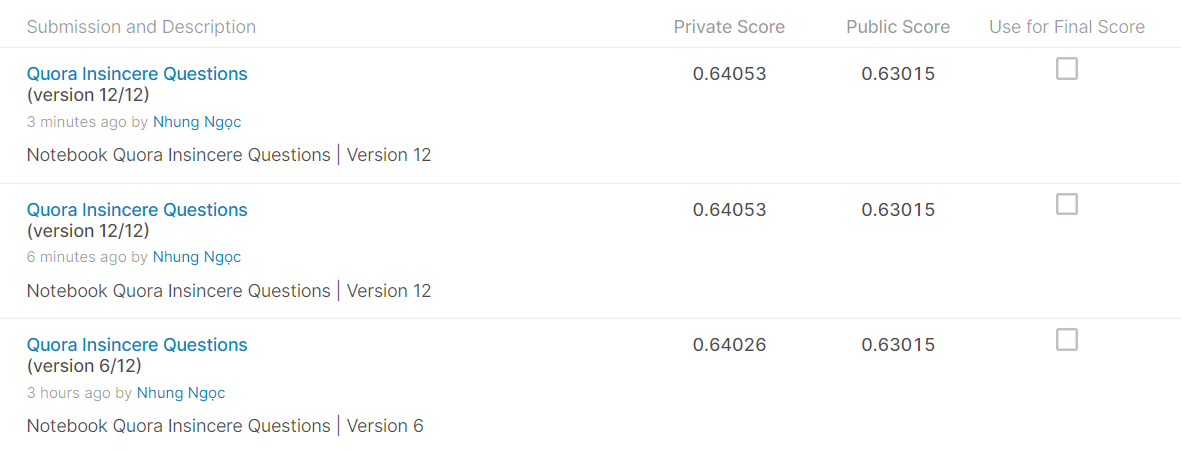